In [1]:
import numpy as np
import BinaryReader
import TFRecordsHandler
import tensorflow as tf
import sklearn

In [20]:
def instance_condition(file_name, instance_label):
    position_string = file_name.split(".")[0]
    b_pos_str, c_pos_str = position_string.split("_")
    b_pos = int(b_pos_str[1:])
    c_pos = int(c_pos_str[1:])
    if b_pos == 0 and c_pos == 0:
        instance_label = 0
        is_corner = True
    elif b_pos == 13 and c_pos == 7:
        instance_label *= 2
        instance_label += 1
        is_corner = True
    # elif b_pos == 19 and c_pos == 19:
    #     is_corner = True
    #     instance_label += 1
    else:
        is_corner = False
    return is_corner, instance_label

In [21]:
import os
data_location = "/mnt/NewHDD/tfrecords"
all_input_files = []
all_labels = []
for instance in os.listdir(data_location):
    label = int(instance[0])
    instance = os.path.join(data_location, instance)
    for file in os.listdir(instance):
        is_corner_instance, corner_label = instance_condition(file, label)
        if is_corner_instance:
            all_input_files.append(os.path.join(instance, file))
            all_labels.append(corner_label)

In [22]:
dataset = TFRecordsHandler.get_dataset_small(all_input_files)

In [23]:
mean_scans = []
var_scans = []
for elem, label in zip(dataset, all_labels):
    if label == 0:
        mean_scans.append(np.mean(elem[0].numpy().reshape((1536, 102*102)), axis=1))
        var_scans.append(np.var(elem[0].numpy().reshape((1536, 102*102)), axis=1))

In [42]:
mean_scans_sub = []
var_scans_sub = []
i = 0
for elem, label in zip(dataset, all_labels):
    if label > 0:
        to_calc = (elem[0].numpy().reshape((1536, 102*102)) - mean_scans[i].reshape((1536, 1))) / \
        var_scans[i].reshape((1536, 1))**0.5
        mean_scans_sub.append(np.mean(to_calc, axis=1))
        var_scans_sub.append(np.var(to_calc, axis=1))
        i += 1

In [132]:
np.mean(var_scans_sub, axis=1)

array([1.57882086, 2.69278313, 2.5873695 , 1.81756661, 1.87575505,
       3.16777028, 1.88884017, 2.2427768 , 2.81948677, 2.65843428,
       2.05180787, 2.14469899, 1.72169503, 2.49952667, 2.22612958,
       2.68886989, 3.3074033 , 2.05130451, 2.21651597, 1.97688459,
       2.89408627, 3.05631123, 2.39633491, 2.13097485, 2.33495938,
       2.86108985, 2.29625804, 2.31255999, 2.84242674, 2.0349991 ,
       1.90512384, 1.73757458, 1.84974399, 2.34095452, 1.55199915,
       2.8958207 ])

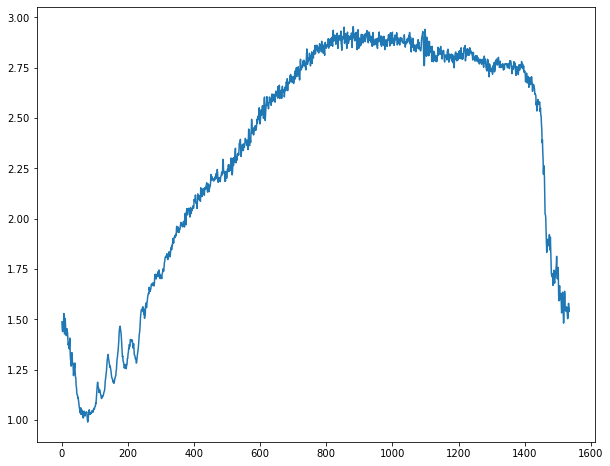

In [135]:
fig = plt.figure(figsize=(10, 8))
plt.plot(np.mean(var_scans_sub, axis=0))

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20,n_iter = 2000)
var_embedding = tsne.fit_transform(var_scans_sub)

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 35 nearest neighbors...
[t-SNE] Indexed 36 samples in 0.000s...
[t-SNE] Computed neighbors for 36 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 36 / 36
[t-SNE] Mean sigma: 16.321266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.869522
[t-SNE] KL divergence after 1250 iterations: 0.172807


In [142]:
from umap import UMAP
umap = UMAP(n_neighbors=11)
var_embedding = umap.fit_transform(var_scans_sub)

[Text(0.5, 1.0, 'Retina Variance then UMAP projection')]

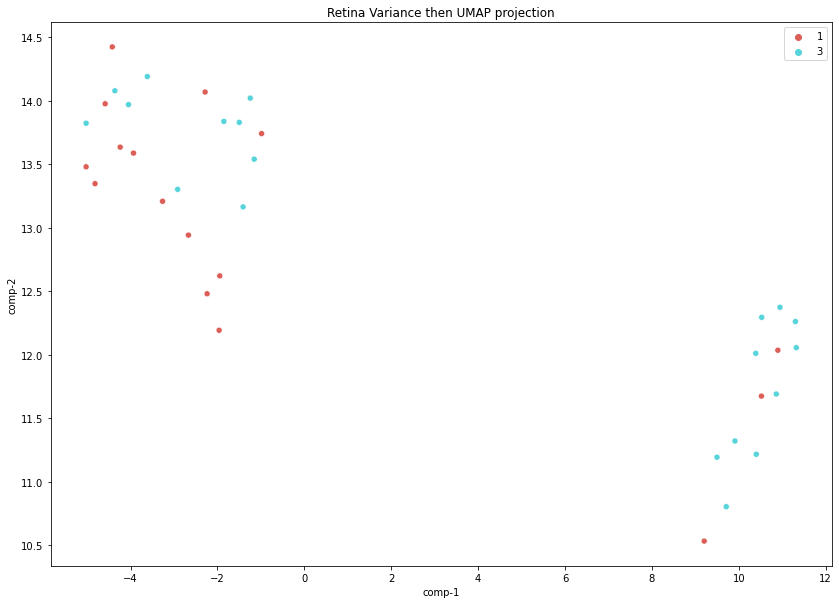

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame()
df["y"] = [label for label in all_labels if label > 0]
df["comp-1"] = var_embedding[:,0]
df["comp-2"] = var_embedding[:,1]

fig = plt.figure(figsize=(14,10))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Retina Variance then UMAP projection")

# TODO: Mean of all Variances plot

In [117]:
outliers_10 = []
for i, value in enumerate(var_embedding[:, 1]):
    if value < -3:
        outliers_10.append(i) -> 13025

In [115]:
outliers_30 = []
for i, value in enumerate(var_embedding[:,0]):
    if value > -1:
        outliers_30.append(i)
outliers_30_files = []
for i in outliers_30:
    j = 0
    for file, label in zip(all_input_files, all_labels):
        if label > 0:
            if i == j:
                outliers_30_files.append(file)
            j += 1

In [39]:
outliers_9 = []
for i, value in enumerate(var_embedding[:,1]):
    if value < -50:
        outliers_9.append(all_input_files[i])

In [3]:
import BinaryReader
import InputList

br = BinaryReader.BinaryReader()
gen = br.instance_from_binaries_generator(InputList.diabetic_training_files[2:3])
i = 0
for elem in gen:
    # if i==0:
    #     border_elem = elem
    #     mean_border_ascan = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
    #     var_border_ascan = np.var(elem[0].reshape((1536, 102*102)), axis=1)
    i += 1
    if i == 31:
        retina_elem1 = elem
        mean_retina_ascan1 = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
        var_retina_ascan1 = np.var(elem[0].reshape((1536, 102*102)), axis=1)
    if i == 50:
        retina_elem2 = elem
        mean_retina_ascan2 = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
        var_retina_ascan2 = np.var(elem[0].reshape((1536, 102*102)), axis=1)
        break

In [11]:
import BinaryReader
import InputList

br = BinaryReader.BinaryReader()
gen = br.instance_from_binaries_generator([InputList.diabetic_training_files[1]])
i = 0
for elem in gen:
    border_elem = elem
    mean_border_ascan_h3 = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
    var_border_ascan_h5 = np.var(elem[0].reshape((1536, 102*102)), axis=1)
    break


In [4]:
gen = br.instance_from_binaries_generator(InputList.healthy_training_files[:1])
i = 0
for elem in gen:
    # if i==0:
    #     border_elem = elem
    #     mean_border_ascan = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
    #     var_border_ascan = np.var(elem[0].reshape((1536, 102*102)), axis=1)
    i += 1
    if i == 31:
        retina_elem3 = elem
        mean_retina_ascan3 = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
        var_retina_ascan3 = np.var(elem[0].reshape((1536, 102*102)), axis=1)
    if i == 50:
        retina_elem4 = elem
        mean_retina_ascan4 = np.mean(elem[0].reshape((1536, 102*102)), axis=1)
        var_retina_ascan4 = np.var(elem[0].reshape((1536, 102*102)), axis=1)
        break

In [158]:
retina1 = retina_elem2[0]
retina2 = retina_elem1[0]
border1 = border_elem[0]
all_elem = [border1, retina1, retina2]

In [159]:
new_all = []
for elem in all_elem:
    new_all.append(elem.astype("int64") - 32743)

In [160]:
np.mean(new_all[0])

0.38034049404075354

In [161]:
newer_all = []
for elem in new_all:
    newer_all.append(np.abs(elem))

In [164]:
newer_all[0].shape

(1536, 102, 102, 1)

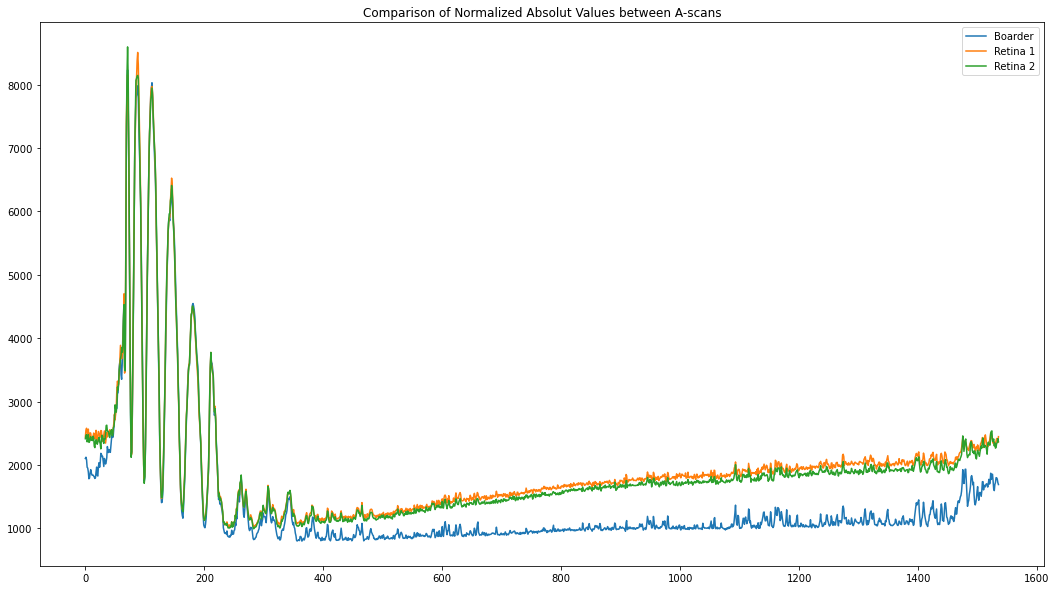

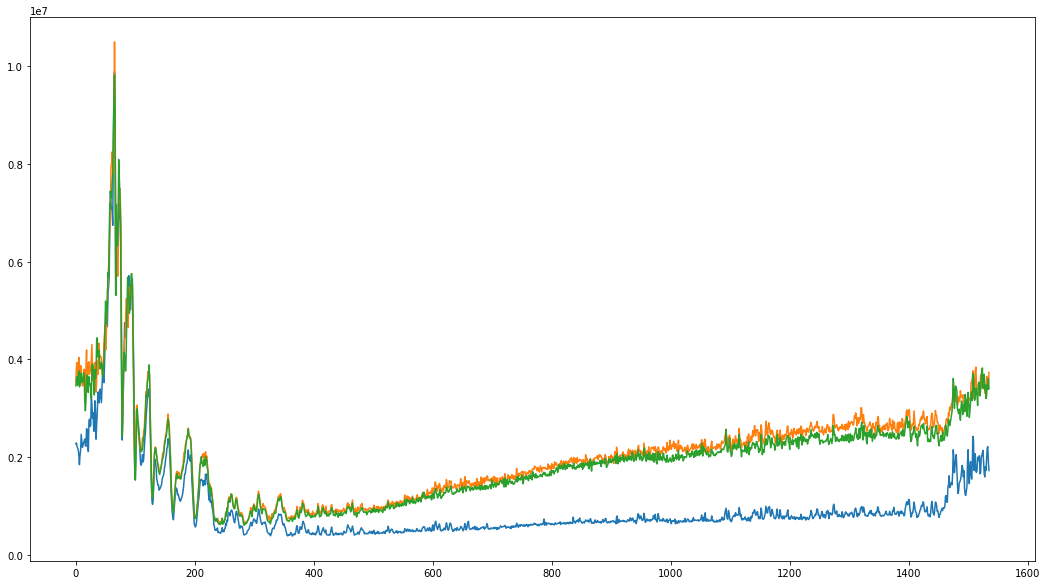

In [168]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,10))
plt.title("Comparison of Normalized Absolut Values between A-scans")
for elem in newer_all:
    plt.plot(np.mean(elem.reshape((1536, 102*102)), axis=1))
plt.legend(["Boarder", "Retina 1", "Retina 2"])
plt.savefig("normalize_absolut.png")
fig = plt.figure(figsize=(18,10))
for elem in newer_all:
    plt.plot(np.var(elem.reshape((1536, 102*102)), axis=1))

In [54]:
def euclidean_distance(x,y):
  return (sum(pow(a-b,2) for a, b in zip(x, y)))**0.5

In [96]:
#scans = [mean_border_ascan_d1, mean_border_ascan_d2, mean_border_ascan_h1, mean_border_ascan_h2, mean_border_ascan_h3]
scans = [var_border_ascan_d1, var_border_ascan_d2, var_border_ascan_h1, var_border_ascan_h2, var_border_ascan_h3, var_border_ascan_h4]
res = []
for scan in scans:
    res2 = []
    for scan2 in scans:
        res2.append(euclidean_distance(scan,scan2))
    res.append(res2)

In [12]:
from sklearn.manifold import TSNE
embedding = TSNE().fit_transform(np.array([var_border_ascan_h5, var_border_ascan_h4]))

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
embedding[:,1]

array([ 158.39442, -158.39442], dtype=float32)

Text(0.5, 1.0, 'Comparison of Means between A-scans')

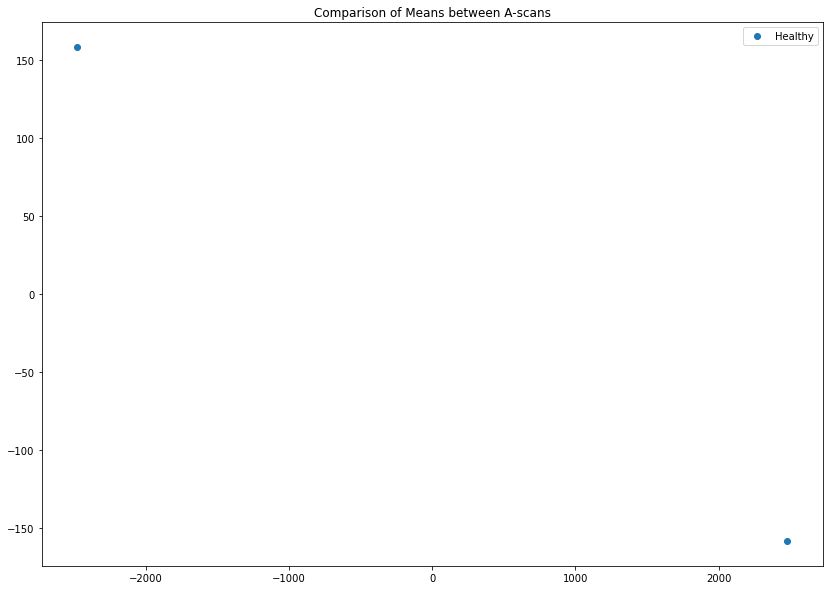

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
plt.plot(embedding[:,0], embedding[:,1], "o")
#plt.plot(var_border_ascan_h2)
#plt.plot(var_border_ascan_d1)
#plt.plot(var_border_ascan_d2)
plt.legend(["Healthy","Healthy", "Diabetic", "Diabetic"])
plt.title("Comparison of Means between A-scans")
#plt.savefig("variance_plot.png")

In [83]:
mean_border_ascan_h2[400:800]

(1536,)

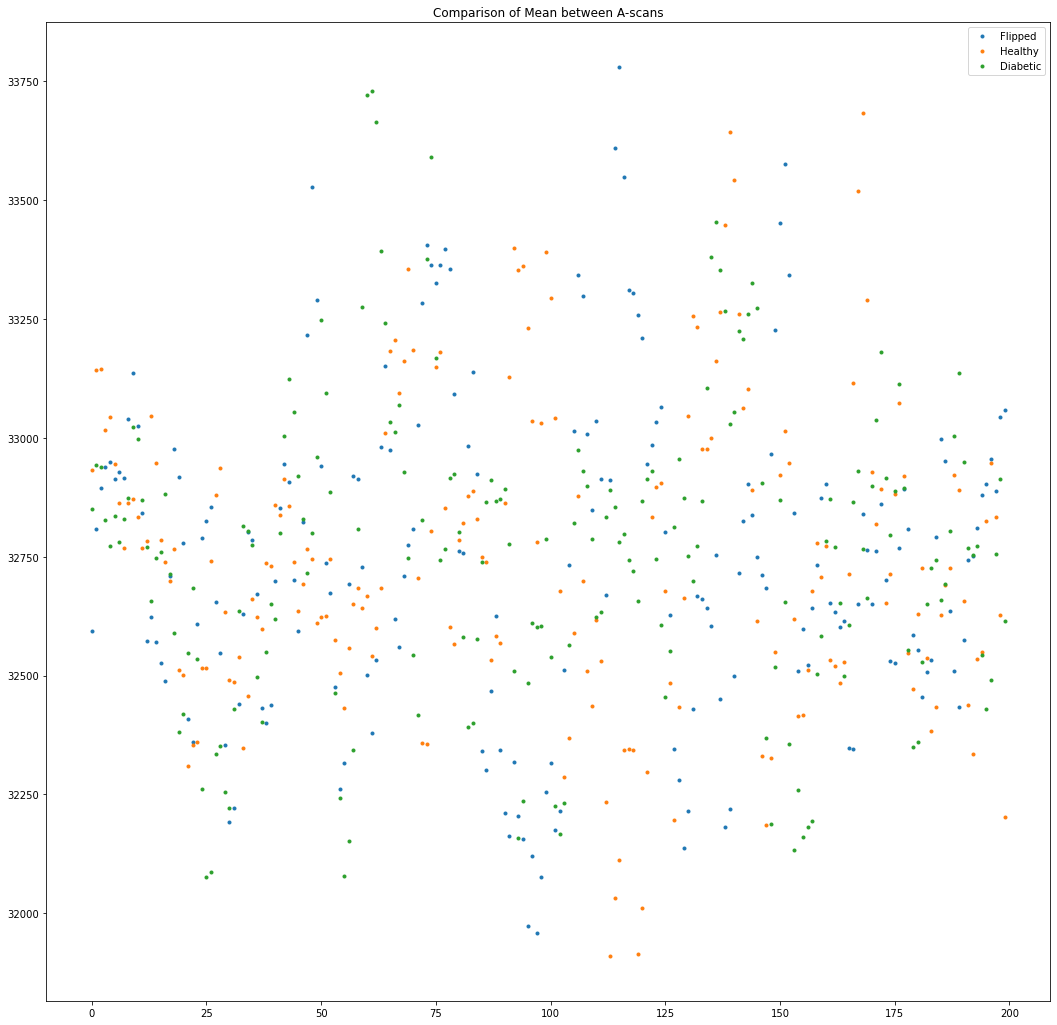

In [86]:
# TODO: Move to Utils file?
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,18))
plt.hbar(mean_border_ascan_h2[500:700], ".")
plt.plot(mean_border_ascan_h1[500:700], ".")
plt.plot(mean_border_ascan_d1[500:700], ".")
plt.legend(["Flipped", "Healthy", "Diabetic"])
plt.title("Comparison of Mean between A-scans")
plt.savefig("mean_plot.png")

In [39]:
diciti = {"values": [], "labels":[]}

In [42]:
def helper(th, my_diciti):
    values = th[0].reshape((1536, 102*102))
    for i in range(102*102):
        my_diciti["values"].append(values[:, i])
        my_diciti["labels"].append(th[1])
    return my_diciti

In [44]:
helper(border_elem, diciti)

{'values': [array([35168, 34208, 32960, ..., 32608, 36064, 34944], dtype=uint16),
  array([35040, 35104, 34976, ..., 28448, 29536, 32128], dtype=uint16),
  array([32992, 33376, 33184, ..., 32288, 32064, 32576], dtype=uint16),
  array([34272, 34720, 32384, ..., 31680, 30720, 33376], dtype=uint16),
  array([33568, 33856, 33088, ..., 27616, 26944, 32544], dtype=uint16),
  array([38112, 35264, 35328, ..., 34240, 27712, 28512], dtype=uint16),
  array([33248, 31488, 35520, ..., 35776, 34400, 32736], dtype=uint16),
  array([29600, 28640, 33536, ..., 32000, 32064, 29312], dtype=uint16),
  array([33184, 31488, 31200, ..., 32768, 33792, 33600], dtype=uint16),
  array([33568, 33216, 33856, ..., 29856, 24320, 29856], dtype=uint16),
  array([32512, 33824, 32768, ..., 33760, 30848, 33536], dtype=uint16),
  array([33088, 26240, 34976, ..., 35648, 33248, 35264], dtype=uint16),
  array([36512, 35072, 33408, ..., 35936, 34784, 31520], dtype=uint16),
  array([32640, 32096, 34016, ..., 30784, 32672, 32352

In [6]:
import tensorflow.keras as k

inp = k.layers.Input(shape=(1536, 1), dtype="float32")

#flatten and fully connected layer
out, weights = k.layers.AdditiveAttention(name="a")([inp, inp], return_attention_scores=True)


model = k.Model(inputs=inp, outputs=out)
model.compile(optimizer=k.optimizers.Adam(lr=1e-4), loss=k.losses.BinaryCrossentropy(from_logits=True))
model.summary()
